<a href="https://colab.research.google.com/github/troncosofranco/ML-Notebooks/blob/main/A_B_testing_(Digital_Marketing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement
FaceZonGoogAppFlix, the leading e-commerce titan, has enlisted our services as a data science consultancy firm. Their objective is to explore the effectiveness of a potentially new website design, which they hope will boost their current conversion rates of 12% by at least 35%.

#Solution approach
This notebook performes multiple testing, including A/B, to analyze the statiscial relationship between the variables.

#Data attributes

The data was obtained from [Hakan Özler](https://github.com/ozlerhakan/ab-test/blob/master/ab_data.csv). The data set contains the following attribures:
1. User ID
2. Timestamp
3. Group: control/treatment
4. Landing Page: Old Page/New Page
5. Converted: 0 (No)/ 1 (yes)


#1. Import Modules

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import random
random.seed(42) #get the same answers

import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import seaborn as sns
from math import ceil
import scipy.stats as stats
import statsmodels.stats.api as sms

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
plt.style.use('seaborn-whitegrid')

#2. Load Data

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
#df.info()
df.shape

(294478, 5)

The dataset contains 294478 instances. Two attributes are numeric (user_id and converted)

#3. Data cleaning

In [4]:
df.user_id.nunique()

290584

The unique values of user ID is lower than the number of instances.

In [5]:
df.user_id.value_counts().sort_values(ascending=False)

805339    2
856917    2
834370    2
703112    2
823617    2
         ..
898500    1
731985    1
759926    1
941223    1
715931    1
Name: user_id, Length: 290584, dtype: int64

The dataset contains duplicates. Only remains the first instance.

In [6]:
df.drop_duplicates(subset ='user_id',keep ='first',inplace = True)
df.user_id.nunique()

290584

In [7]:
df.shape

(290584, 5)

In [8]:
#Check for missing values
df.isna().sum()


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No missing values in dataset.

In [9]:
#Checking for mismatch in this dataset
n_treat = df[df["group"] == "treatment"].shape[0]
n_new_page = df[df["landing_page"] == "new_page"].shape[0]

print('The difference between treatment and new page instance is', n_treat - n_new_page)

The difference between treatment and new page instance is 32


The number of users given treatment differs from the user number landed in new page.

In [10]:
# Number of user given treatment landed in old page
print('User given treatment landed in old page:',df[(df["group"] == "treatment") & (df["landing_page"] == "old_page")].shape[0])

User given treatment landed in old page: 1038


1038 users classified as getting treatment landed on the old page.

In [11]:
# Control group landed in new page
print('Control group landed in new page:',df[(df["group"] == "control") & (df["landing_page"] == "new_page")].shape[0])

Control group landed in new page: 1006


 1006 users classified as control group landed on the new page

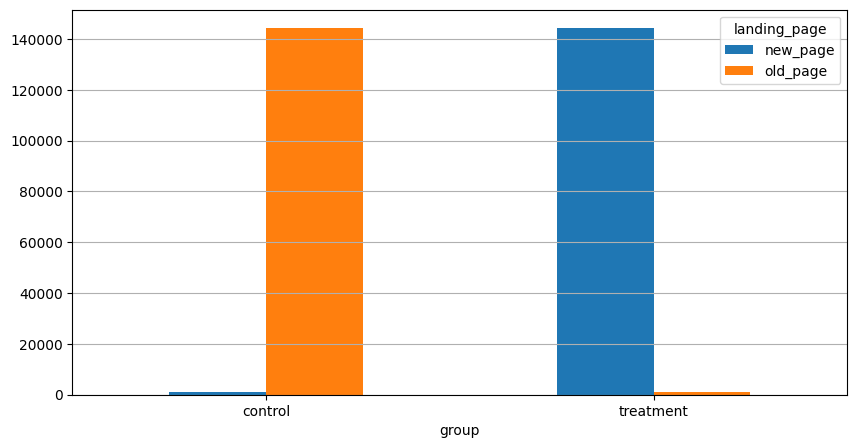

In [12]:
# Cross tabulation

mpl.style.use('default')
CrosstabResult=pd.crosstab(index=df['group'],columns=df['landing_page'])
CrosstabResult.plot.bar(figsize=(10,5), rot = 0 )
plt.grid(axis = 'y')

The previous figure indicates overlapping between group and landing page values.

In [13]:
CrosstabResult

landing_page,new_page,old_page
group,,
control,1006,144226
treatment,144314,1038


In [14]:
# Proportion of mismatched instances
n_mismatch = CrosstabResult.loc['control','new_page'] + CrosstabResult.loc['treatment','old_page']
percent_mismatch = round(n_mismatch/len(df) * 100,2)

In [15]:
print(f'Percent of mismatched rows: {percent_mismatch} %')

Percent of mismatched rows: 0.7 %


The mismatched rows represents only 0.7% of the whole data. Hence, the mismatched data in removed.

In [16]:
df = df[(df["group"] == "treatment") & (df["landing_page"] == "new_page")
        |(df["group"] == "control") & (df["landing_page"] == "old_page")]


In [17]:
# check mismatch data
print("Current mismatch data: " + str(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]))

Current mismatch data: 0


In [18]:
df = df.drop_duplicates("user_id")

In [19]:
# Check duplicates
print("Number of duplicated user : "+str(len(df[df.duplicated(subset = ["user_id"])==True])))

Number of duplicated user : 0


#3. Experimental design

A two tailed test is applied.
- Null hypothesis:  H0: p=p0
- Alternative hypothesis:  Ha: p≠p0
 
where p and p0 stand for the conversion rate of the new and old page, respectively. The confidence level selected is 95%. Hence, α = 0.05
 
###Metric
The conversion rate is a binary variable:
- 0 : The user did not pay for the product (not converted)
- 1 : The user pay for the product (converted)


###Determining sample size

In general, large sample size coupled with small confidence interval leads to higher chance of detecting difference between two groups. 

In this case, there is no information about how big a difference of conversion rate should be. For this reason, it is assumed Rate conversion of +3%.

What is the conversion rate of control group?

In [20]:
df.user_id = df.user_id.astype(str)

control_convert_rate = df[df['group'] == 'control']['converted'].mean() * 100

print ("Conversion rate of control group : "+ str(round(control_convert_rate,3)) + "%")

Conversion rate of control group : 12.029%


Based on the previous assumption, It can be used 12.029% and 15.029% to determine the expected effect size.

In [27]:
effect_size = sms.proportion_effectsize(control_convert_rate/100, control_convert_rate/100+0.03)

# Sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, # Default balue
    alpha=0.05, # Confidence
    ratio=1
    )                                                  

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print("required data for each group : " + str(required_n))

required data for each group : 2035


At least 2035 observations for each group are required.

In [28]:
df.group.value_counts()

treatment    144314
control      144226
Name: group, dtype: int64

Each group have around 144000 data for each group, which is larger than the data required for the experiment.

In [29]:
conversion_rates = df.groupby('group')['converted']

# Std. deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)  

# Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof=0)            

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.5f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.12029,0.32530,0.00086
treatment,0.11873,0.32347,0.00085


Old page converts more than the new page, 12% and 11.9%, respectively.

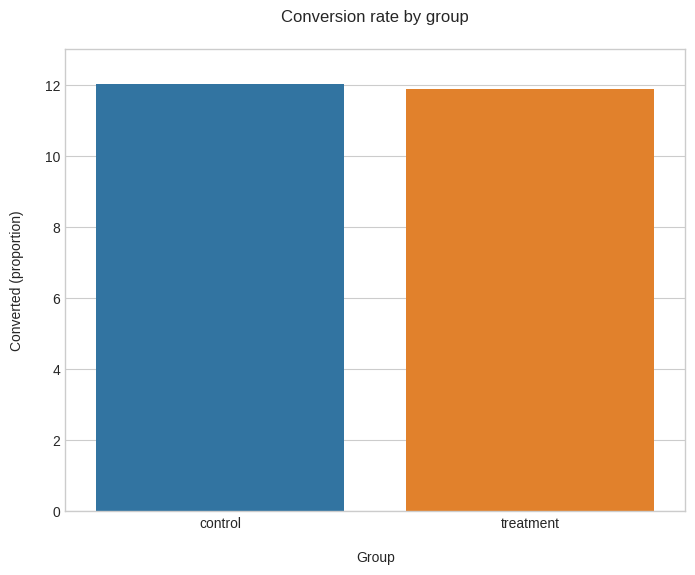

In [32]:
plt.figure(figsize=(8,6))
sns.barplot(x=df['group'], y=df['converted']*100, ci=False)

plt.ylim(0, 13)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

The initial evidence suggests that new page has no significant impact in conversion.

#4. Hypothesis Testing (A/B Test)

z-test to calculate p-value can be used considering the large volume of data. Otherwise, t-student test can be performed instead.

In [35]:
# p-value and confidence interval for each group

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.29
p-value: 0.196
ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.117, 0.120]


#5. Conclusions
- p-value = 0.190, which is above than α=0.05 threshold. 
- The p-value suggests that the null hypothesis (H0) can not be rejected. Hence, the new page did not perform significantly different (or even better) than the old page.
- The confidence interval of the treatment group [0.117, 0.120] or 11.7-12% includes the baseline value of 12.029% and does not include the target value of 15.029% (2% increase in conversion rate).